# Plug-and-play in silico ChIP

In [3]:
# Input:
# RNA SCE at choosen resolution
# ATAC SCE at choosen resolution
# Both need to contain lognormalised counts
# Both need to be matched & in the right order

In [ ]:
1

In [ ]:
###################
## Load packages
###################
suppressPackageStartupMessages({
    library(scran)
    library(scater)
})
source('utils.R')

In [ ]:
1

In [5]:
###################
## I/O
###################
io = list()
io$basedir = '/bi/home/lij/data/gastrulation_multiome_10x/'

## NMP trajectory
#io$RNA_sce = file.path(io$basedir, '/results/rna/metacells/trajectories/nmp/SingleCellExperiment_metacells.rds')
#io$ATAC_sce = file.path(io$basedir, '/results/atac/archR/metacells/trajectories/nmp/PeakMatrix/PeakMatrix_summarized_experiment_metacells.rds')

## blood trajectory
# io$outdir <- file.path(io$basedir,"results/rna_atac/gene_regulatory_networks/metacells/trajectories/blood")
# io$ATAC_sce = file.path(io$outdir,sprintf("PeakMatrix_summarized_experiment_metacells.rds"))
# io$RNA_sce = file.path(io$outdir,"SingleCellExperiment_metacells.rds")

## All celltypes
#io$RNA_sce = file.path(io$basedir, '/results/rna/metacells/all_cells/SingleCellExperiment_metacells.rds')
#io$ATAC_sce = file.path(io$basedir, '/results/atac/archR/metacells/all_cells/PeakMatrix/PeakMatrix_summarized_experiment_metacells.rds')

## All celltype pseudobulk
io$RNA_sce = file.path(io$basedir, '/results/rna/pseudobulk/celltype/SingleCellExperiment_pseudobulk.rds')
io$ATAC_sce = file.path(io$basedir, '/results/atac/archR/pseudobulk/celltype/PeakMatrix/pseudobulk_PeakMatrix_summarized_experiment.rds')

#
io$motifmatcher <- file.path(io$basedir, "data/processed/atac/archR/Annotations/CISBP-Scores.rds")
io$motif2gene <- file.path(io$basedir, "data/processed/atac/archR/Annotations/CISBP_motif2gene.txt.gz")
io$background_peaks = file.path(io$basedir,"/data/processed/atac/archR/Background-Peaks.rds")


In [6]:
#######################
## Load RNA and ATAC 
#######################

# Load SingleCellExperiment
rna.sce <- readRDS(io$RNA_sce)

# Load ATAC SummarizedExperiment
atac.sce <- readRDS(io$ATAC_sce)

# Normalise ATAC data
assayNames(atac.sce) <- "counts"
assay(atac.sce,"logcounts") <- log(1e6*(sweep(assay(atac.sce),2,colSums(assay(atac.sce),na.rm=T),"/"))+1)

# Make sure that samples are consistent
samples <- intersect(colnames(rna.sce),colnames(atac.sce))
rna.sce <- rna.sce[,samples]
atac.sce <- atac.sce[,samples]

print(sprintf("Number of metacells: %s",length(samples)))

[1] "Number of metacells: 37"


In [7]:
# RNA dimreduction

decomp <- modelGeneVar(rna.sce)
decomp <- decomp[decomp$mean > 0.01,]
hvgs <- decomp[order(decomp$FDR),] %>% head(n=2000) %>% rownames

sce_filt <- rna.sce[hvgs,]
sce_filt <- runPCA(sce_filt, ncomponents = 20, ntop=2000)

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


In [8]:
sce_filt <- runUMAP(sce_filt, dimred="PCA", n_neighbors = 20, min_dist = 1.5)

umap.dt <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell"))

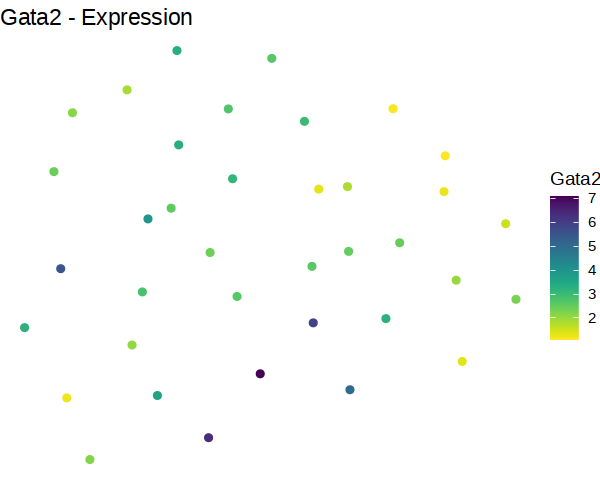

In [9]:
options(repr.plot.width=5, repr.plot.height=4)
gene = 'Gata2'
ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(rna.sce[gene,], 'logcounts')))) + 
    geom_point() +
    viridis::scale_color_viridis(begin=1, end=0, name=gene) + 
    ggtitle(paste0(gene, ' - Expression')) + 
    theme_void()

In [10]:
head(colData(rna.sce))

DataFrame with 6 rows and 0 columns

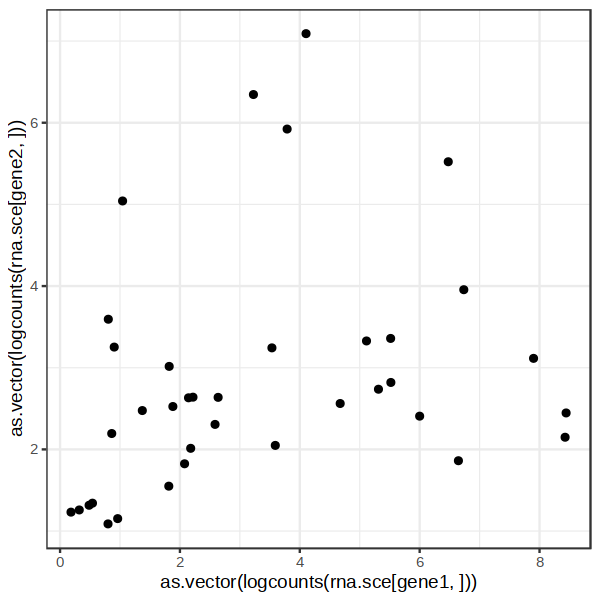

In [11]:
gene1 = 'Eomes'
gene2 = 'Gata2'
options(repr.plot.width=5, repr.plot.height=5)
ggplot(data.table(dummy = rep('a', length(colnames(rna.sce)))), aes(as.vector(logcounts(rna.sce[gene1,])), as.vector(logcounts(rna.sce[gene2,])))) + 
                    geom_point() + 
                    theme_bw()

In [12]:
#######################
## Load Motifs if wanted
#######################
motifmatcher.se <- readRDS(io$motifmatcher)

# Subset peaks
stopifnot(sort(rownames(motifmatcher.se))==sort(rownames(atac.sce)))
motifmatcher.se <- motifmatcher.se[rownames(atac.sce),]

motif2gene.dt <- fread(io$motif2gene)

In [13]:
motifmatcher.se

class: RangedSummarizedExperiment 
dim: 192251 871 
metadata(0):
assays(3): motifScores motifMatches motifCounts
rownames(192251): chr1:3035602-3036202 chr1:3062653-3063253 ...
  chrX:169925487-169926087 chrX:169937064-169937664
rowData names(13): score replicateScoreQuantile ... idx N
colnames(871): TFAP2B_1 TFAP2D_2 ... TBX22_870 TBXT
colData names(1): name

In [14]:
###################
## Correlate TF-expr & Region-accessibility
###################  
a = Sys.time()
tf2peak_cor.se = cor_TF_acc(rna.sce, 
                          atac.sce, 
                          TFs_filt = NULL,  # c('SOX17', 'MYBL1') -> test runs
                          motifmatcher.se = motifmatcher.se, 
                          motif2gene.dt = motif2gene.dt,
                          correlation_method = "pearson", 
                          remove_motifs = c("T_789"))
b = Sys.time()
b-a

[1] "Removing 0 TFs that have duplicated gene-motif pairs:\n"


Correlate TF-expr & Region-accessibility for 738 TFs



Time difference of 49.80964 secs

In [15]:
gata1 = assay(tf2peak_cor.se[, 'GATA1'], 'cor')

In [16]:
as.data.table(as.matrix(gata1), keep.rownames=T) %>% .[order(GATA1)] %>% head()

rn                        GATA1 
1 chr2:30758339-30758939    -0.864
2 chr9:48898438-48899038    -0.837
3 chr15:101970432-101971032 -0.828
4 chr11:99574015-99574615   -0.814
5 chr2:80448187-80448787    -0.812
6 chr5:114467253-114467853  -0.807

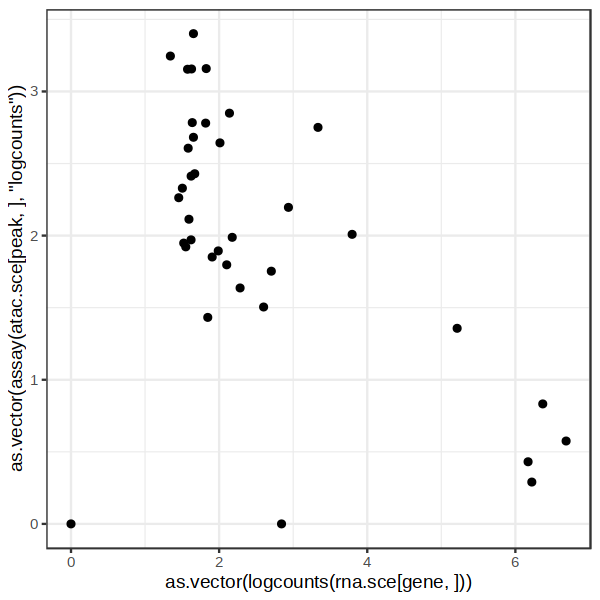

In [17]:
gene = 'Gata1'
peak = 'chr3:121539657-121540257'
options(repr.plot.width=5, repr.plot.height=5)
ggplot(data.table(dummy = rep('a', length(colnames(rna.sce)))), aes(as.vector(logcounts(rna.sce[gene,])), as.vector(assay(atac.sce[peak,], 'logcounts')))) + 
                    geom_point() + 
                    theme_bw()

In [18]:
summary(duplicated(colnames(tf2peak_cor.se)))

   Mode   FALSE 
logical     738 

In [19]:
######################################
## Create virtual chip-seq library 
######################################
a = Sys.time()
motifmatcher_chip = silico_chip(atac.sce = atac.sce, 
                           tf2peak_cor.se = tf2peak_cor.se,
                           motifmatcher.se = motifmatcher.se,
                           motif2gene.dt = motif2gene.dt, 
                           min_number_peaks = 50,
                           TFs_filt = NULL, 
                           remove_motifs = c("T_789"),
                           cores = detectCores())

motifmatcher_chip.se = motifmatcher_chip$motifmatcher_chip.se
virtual_chip.dt = motifmatcher_chip$virtual_chip.dt
b = Sys.time()
b-a

[1] "Number of peaks: 192251"
[1] "Predicting TF binding sites..."
[1] "Number of TFs: 738"
[1] "Updating motifmatchr results using the virtual ChIP-seq library..."


Time difference of 35.73179 secs

In [20]:
virtual_chip.dt = motifmatcher_chip$virtual_chip.dt


In [21]:
head(virtual_chip.dt)

peak                     score correlation_score max_accessibility_score
1 chr2:153425804-153426404 0.61  0.81              3.75                   
2 chr15:98033194-98033794  0.54  0.76              3.42                   
3 chr7:98404013-98404613   0.53  0.76              3.62                   
4 chr9:67320850-67321450   0.53  0.84              3.19                   
5 chr18:65530295-65530895  0.51  0.74              3.49                   
6 chr7:93037659-93038259   0.51  0.79              3.36                   
  motif_score tf    
1 0.89        TFAP2B
2 0.93        TFAP2B
3 0.87        TFAP2B
4 0.91        TFAP2B
5 0.89        TFAP2B
6 0.89        TFAP2B

In [31]:
head(to.plot)

idx                       value     score motif_score max_accessibility_score
1 chr10:100023695-100024295 143.01099  0.30 0.95        2.57                   
2 chr10:100034910-100035510   1.72115  0.02 0.88        2.06                   
3 chr10:100042137-100042737   1.46037  0.01 1.00        2.25                   
4 chr10:100065912-100066512  37.29132  0.31 1.00        2.98                   
5 chr10:10038933-10039533     2.45133 -0.03 0.89        2.23                   
6 chr10:10051908-10052508     1.14744 -0.02 0.91        1.66                   
  chip_anno
1 CDX2     
2 CDX2     
3 CDX2     
4 CDX2     
5 CDX2     
6 CDX2

In [22]:
######################################
## silico_chipseq_validation
######################################
library(GenomicRanges)
library(rtracklayer)

io$chip_dir.prefix <- "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/revisions/chip_files"
io$chip.files <- c(
  "CDX2" = file.path(io$chip_dir.prefix, "GSM2253707_Cdx2_wtEpiSCs_24h_rep1_mm10.bw"),
  "TAL1" = file.path(io$chip_dir.prefix, "GSM1692858_HP_Tal1.bw"),
  "GATA1" = file.path(io$chip_dir.prefix, "GSM1692851_HP_Gata1.bw"),
  "FOXA2" = file.path(io$chip_dir.prefix, "Foxa2.d5FS.bw"),
  "GATA4" = file.path(io$chip_dir.prefix, "GSM3223330_Gata4.d5FS.r1_m1.ucsc.bigWig"),
  "TBX5" = file.path(io$chip_dir.prefix, "Tbx5_WT_CP.bw")
)
peak_metadata.gr = makeGRangesFromDataFrame(rowData(atac.sce))
stopifnot(file.exists(io$chip.files))
TFs <- names(io$chip.files)

## calculate background ChIP signal 
chip_background.dt <- mclapply(TFs, function(i) {
  data.table(
    chip_anno = i,
    median = median(import.bw(BigWigFile(io$chip.files[[i]]))$score)
  )
}, mc.cores=10) %>% rbindlist

## calculate signal 
peak_metadata_ucsc.gr <- peak_metadata.gr; seqlevelsStyle(peak_metadata_ucsc.gr) <- 'UCSC'
peak_metadata_ncbi.gr <- peak_metadata.gr; seqlevelsStyle(peak_metadata_ncbi.gr) <- 'NCBI'
tf2seqstyle <- rep("UCSC",length(TFs)); names(tf2seqstyle) <- TFs
tf2seqstyle["TBX5"] <- "NCBI"

to.plot <- mclapply(TFs, function(i){
  # Load virtual ChIP-seq library
    virtual_chip_tmp = copy(virtual_chip.dt)[tf==i] %>% 
        setnames('peak', 'idx') %>% 
        .[,idx:=str_replace(idx,":","-")] %>%
        .[,chr:=strsplit(idx,"-") %>% map_chr(1)] %>%
        .[,start:=as.integer(strsplit(idx,"-") %>% map_chr(2))] %>%
        .[,end:=as.integer(strsplit(idx,"-") %>% map_chr(3))] %>%
        .[,idx:=str_replace(idx,"-",":")] %>% 
        setkey(chr,start,end)

    # Load ground truth ChIP-seq data
    if (tf2seqstyle[[i]]=="UCSC") {
        tmp <- peak_metadata_ucsc.gr
    } else if (tf2seqstyle[[i]]=="NCBI") {
        tmp <- peak_metadata_ncbi.gr
    }

    chip.dt <- import.bw(BigWigFile(io$chip.files[[i]]), selection = tmp) %>% as.data.table %>%
        .[,c(1,2,3,6)] %>% setnames(c("chr", "start", "end","value")) %>%
        .[,chr:=as.character(chr)] %>%
        .[,chr:=ifelse(grepl("chr",chr),chr,paste0("chr",chr))] %>%
      setkey(chr,start,end)

      # overlap ATAC peaks with ChIP-seq signal and quantify ChIP signal
    to.plot =  virtual_chip_tmp[,c("idx","chr","start","end")] %>%
        foverlaps(chip.dt, nomatch=0) %>% 
        .[,.(value=sum(value)), b=c("idx")] %>%
        merge(virtual_chip_tmp[,c("idx","score","motif_score", "max_accessibility_score")]) %>%
        .[,chip_anno:=as.factor(i)] %>%
        return
  
}, mc.cores=10) %>% rbindlist

seq.ranges <- seq(0,1,by=0.10); names(seq.ranges) <- as.character(1:length(seq.ranges))

foo <- to.plot %>%
  .[score>=0] %>% 
  merge(chip_background.dt,by="chip_anno") %>%
  .[,log_value:=log(value+1)] %>%
  .[,c("chip_anno","idx","log_value","motif_score","score", "max_accessibility_score")] %>%
  setnames("score","score_rna_atac")

to.plot.compare_models <- foo %>%
  # Model 1: DNA
  # .[,score_dna:=minmax.normalisation(motif_score), by="chip_anno"] %>% 
  # Model 2: DNA + ATAC
  .[,score_dna_atac:=minmax.normalisation(max_accessibility_score * motif_score), by="chip_anno"] %>% .[,score_dna_atac:=score_dna_atac+0.001] %>%
  # Model 3: DNA + ATAC + RNA
  .[,score_rna_atac:=minmax.normalisation(score_rna_atac), by="chip_anno"] %>% .[,score_rna_atac:=score_rna_atac+0.001] %>%
  # Discretise values
  # .[,score_dna_group:=cut(abs(score_dna), breaks=seq.ranges)] %>% .[,score_dna_group:=seq.ranges[as.numeric(score_dna_group)]] %>%
  .[,score_dna_atac_group:=cut(abs(score_dna_atac), breaks=seq.ranges)] %>% .[,score_dna_atac_group:=seq.ranges[as.numeric(score_dna_atac_group)]] %>%
  .[,score_rna_atac_group:=cut(abs(score_rna_atac), breaks=seq.ranges)] %>% .[,score_rna_atac_group:=seq.ranges[as.numeric(score_rna_atac_group)]] %>%
  # Prepare for plotting
  melt(id.vars=c("chip_anno","idx","log_value"), measure.vars=c("score_dna_atac_group","score_rna_atac_group"), variable.name="model", value.name="predicted_value") %>%
  .[,N:=.N,by=c("model","chip_anno","predicted_value")] %>%
  .[,.(mean=mean(log_value,na.rm=T), sd=sd(log_value,na.rm=T), N=.N), by=c("model","chip_anno","predicted_value")] %>%
  # Filter settings with a small number of observations
  .[!is.na(mean) & N>=25]

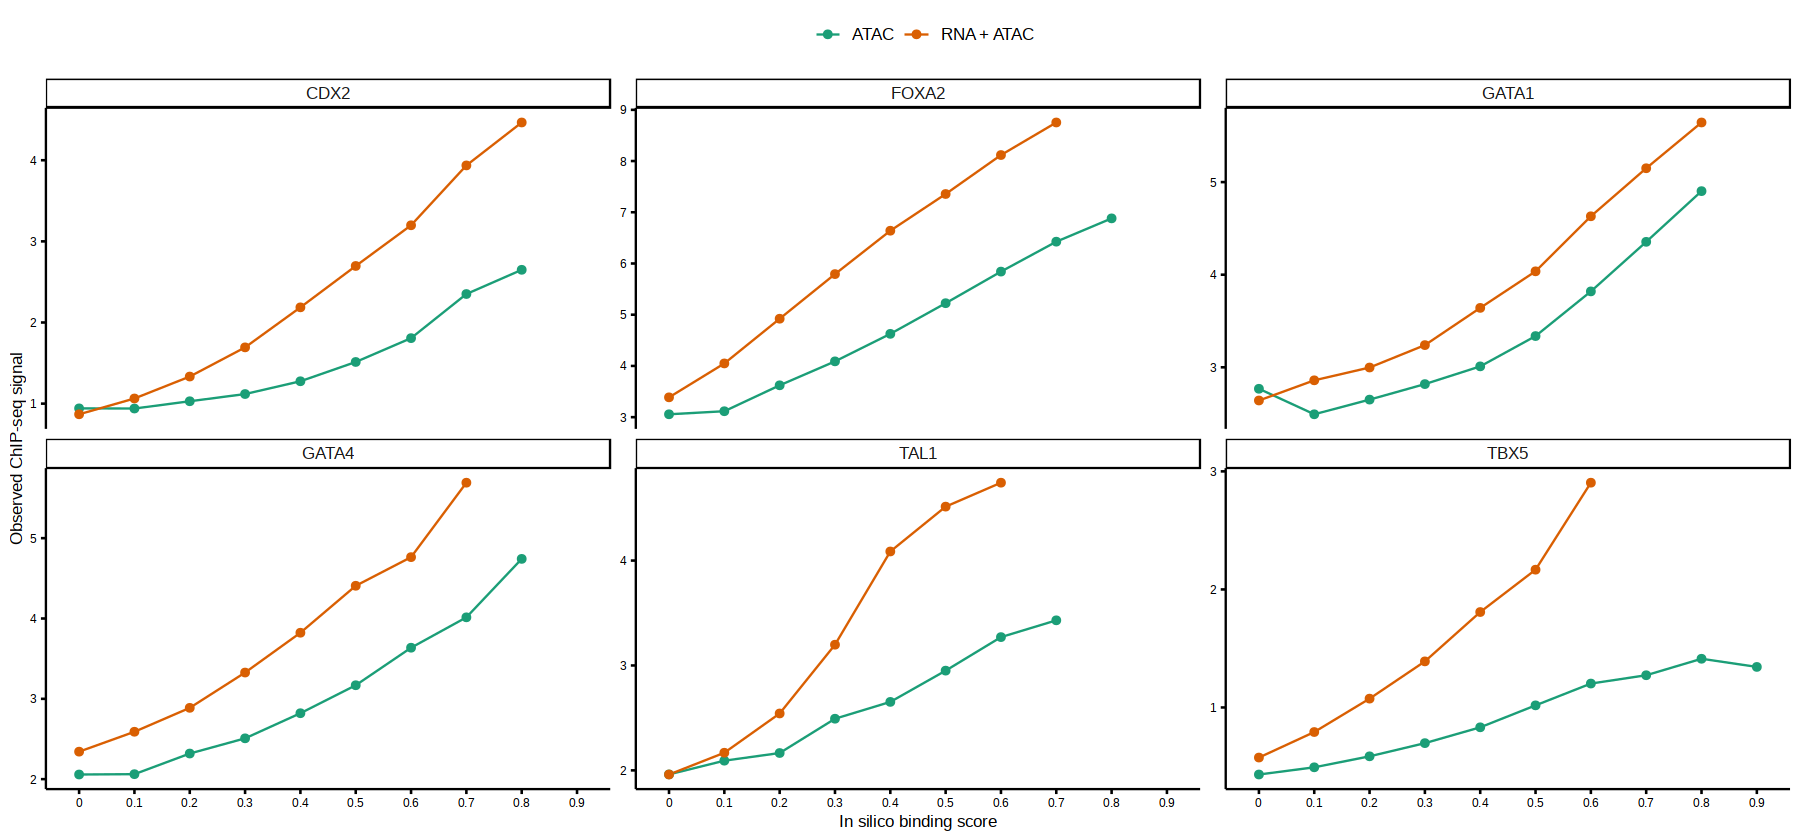

In [23]:
options(repr.plot.width=15, repr.plot.height=7)
ggline(to.plot.compare_models, x="predicted_value", y="mean", color="model", plot_type="b") +
  facet_wrap(~chip_anno, scales="free_y") +
  # geom_errorbar(aes(ymin=log_value-sd, ymax=log_value-sd), width=.2,) +
  scale_color_brewer(palette="Dark2", labels = c("ATAC", "RNA + ATAC")) +
  # scale_color_discrete(labels = c("DNA", "DNA + ATAC", "DNA + ATAC + RNA")) +
  labs(y="Observed ChIP-seq signal", x="In silico binding score") +
  theme(
    strip.background = element_rect(colour="black", fill=NA),
    axis.text = element_text(size=rel(0.55)),
    axis.title = element_text(size=rel(0.8)),
    legend.title = element_blank(),
    # legend.position = c(.26,.87)
    # legend.position = c(.06,.94)
    legend.position = "top"
  )

In [25]:
######################################
## ChromVAR - ChIP-seq
######################################
a = Sys.time()
# load background peak set
bgdPeaks.se <- readRDS(io$background_peaks)

chromvar_deviations.se = chromVAR_chip(atac.sce = atac.sce, 
                                                   motifmatcher_chip.se = motifmatcher_chip.se,
                                                   assay = 'VirtualChipScores',
                                                   background = bgdPeaks.se,
                                                   genome = NULL, # Only needed if background = NULL
                                                   positive_only = TRUE, 
                                                   min_chip_score = 0.15,
                                                   min_number_peaks = 50,
                                                   TFs_filt = NULL,
                                                   test = FALSE,
                                                   method = 'ArchR', # Option 'ArchR' or 'ChromVAR'
                                                   cores = detectCores())
b = Sys.time()
b-a

[1] "Number of matches before filtering negative TF binding values: 18945532"
[1] "Number of matches after filtering negative TF binding values: 10714289"
[1] "Number of matches before filtering based on minimum ChIP-seq score: 10714289"
[1] "Number of matches after filtering based on minimum ChIP-seq score: 1409335"
9 TFs removed because they don't have enough binding sites: E2F3 HOXC12 PAX1 POU1F1 SIM2 TBX1 TBX18 TBX22 TOPORS 
Running ChromVAR-ChIP-seq (ArchR implementation) 


as(<lgCMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "dMatrix") instead



Time difference of 4.106623 mins

In [26]:
chromvar_deviations_original.se = chromVAR_chip(atac.sce = atac.sce, 
                                                   motifmatcher_chip.se = motifmatcher_chip.se,
                                                   assay = 'motifScores',
                                                   background = bgdPeaks.se,
                                                   genome = NULL, # Only needed if background = NULL
                                                   positive_only = FALSE, 
                                                   min_chip_score = 0,
                                                   min_number_peaks = 50,
                                                   TFs_filt = NULL,
                                                   test = FALSE,
                                                   method = 'ArchR', # Option 'ArchR' or 'ChromVAR'
                                                   cores = detectCores())

[1] "Number of matches before filtering based on minimum ChIP-seq score: 18945532"
[1] "Number of matches after filtering based on minimum ChIP-seq score: 18945532"
Running ChromVAR-ChIP-seq (ArchR implementation) 


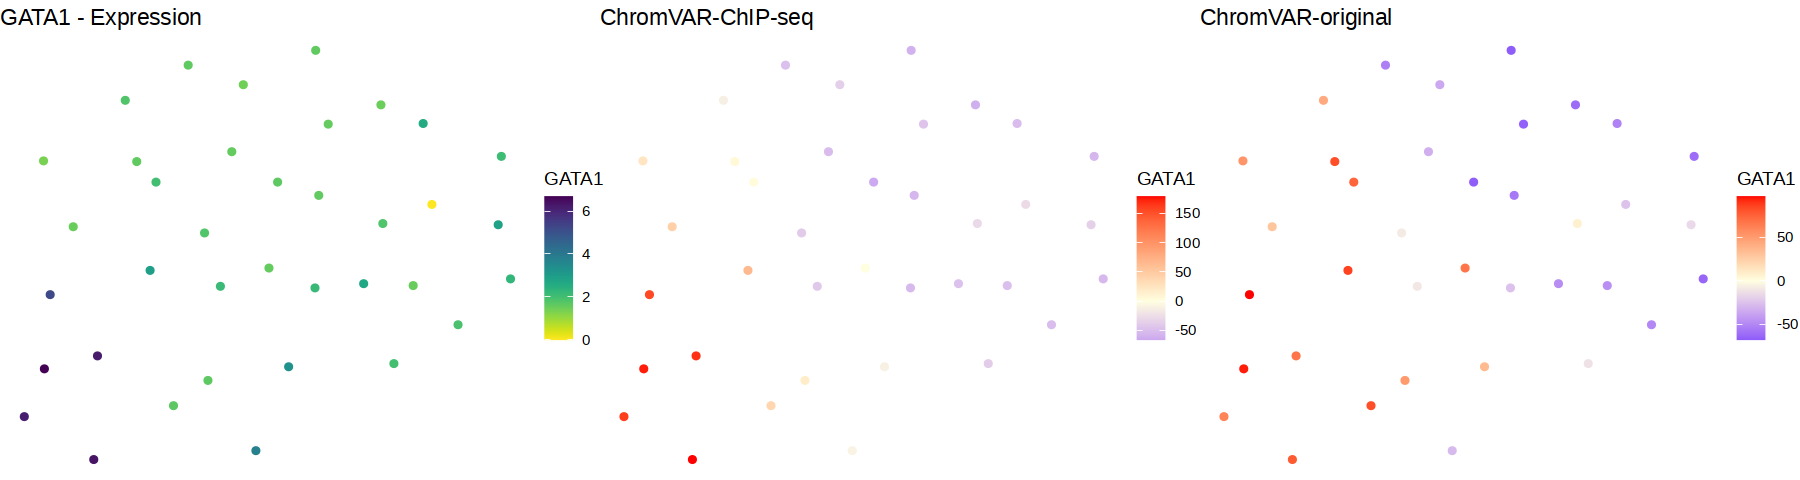

In [27]:
TF = 'GATA1'

p1 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(rna.sce, 'logcounts')[str_to_title(TF),]))) + 
    geom_point() +
    viridis::scale_color_viridis(begin=1, end=0, name=TF) + 
    ggtitle(paste0(TF, ' - Expression')) + 
    theme_void()

p2 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(chromvar_deviations.se, 'z')[TF,]))) + 
    geom_point() +
    scale_color_gradient2(low='blue', mid='lightyellow', high='red', name=TF) + 
    ggtitle('ChromVAR-ChIP-seq') + 
    theme_void()

p3 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(chromvar_deviations_original.se, 'z')[TF,]))) + 
    geom_point() +
    scale_color_gradient2(low='blue', mid='lightyellow', high='red', name=TF) + 
    ggtitle('ChromVAR-original') + 
    theme_void()
options(repr.plot.width=15, repr.plot.height=4)
ggarrange(p1, p2, p3, nrow = 1)

In [28]:
TF_correlations = mclapply(unique(rownames(chromvar_deviations.se)), function(x){
      corr_output <- psych::corr.test(
        x = as.vector(assay(chromvar_deviations.se[x,], 'z')), 
        y = as.vector(assay(rna.sce[str_to_title(x),], 'logcounts')), 
        ci = FALSE,
        method = 'pearson'
      )
    
    tmp = data.table(tf = x,
                     cor = round(corr_output$r,3),
                     pval = round(corr_output$p,10))
    return(tmp)
}, mc.cores = detectCores()) %>% rbindlist() %>%
    .[order(-cor)] %>%
    .[,rank:=.I]

Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


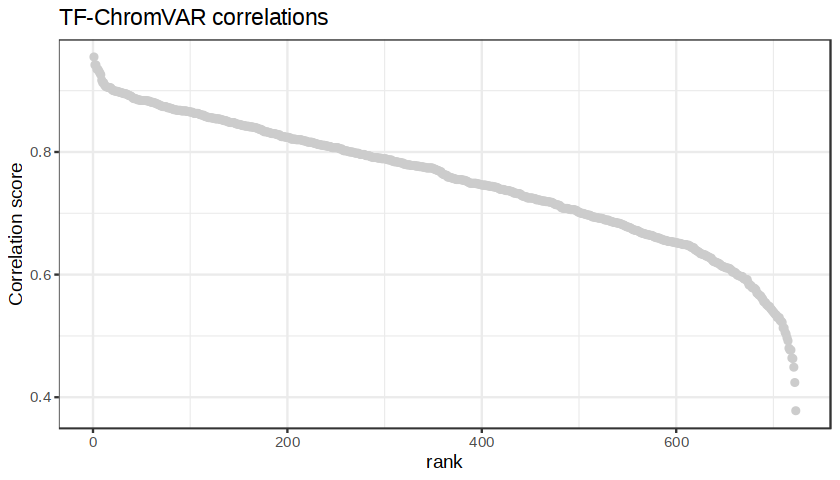

In [29]:
options(repr.plot.width=7, repr.plot.height=4)
ggplot(TF_correlations, aes(rank, cor)) + 
    geom_point(col='gray80') +
    ggrepel::geom_text_repel(data = head(TF_correlations, 10), aes(label=tf)) + 
    ggtitle('TF-ChromVAR correlations') + 
    ylab('Correlation score') + 
    theme_bw()

In [30]:
######################################
## link TF2genes virtual chip
######################################
# peak2gene (also possible to find them in the function, need to supply gene metadata with gene locations(e.g. from biomaRt))
peak2gene <- file.path(io$basedir,"results/atac/archR/peak_calling/peaks2genes/peaks2genes_all.txt.gz") 

## Load peak2gene linkages using only genomic distance
peak2gene.dt <- fread(peak2gene)
head(peak2gene.dt)
summary(peak2gene.dt$dist)

a = Sys.time()
TF2Gene_links = TF2Gene(rna.sce = rna.sce, 
                   motifmatcher_chip.se = motifmatcher_chip.se,
                   peak2gene.dt = peak2gene.dt,
                   min_chip_score = 0.15,
                   distance = 1.5e5, # Can not be higher than the max distance in peak2gene.dt, unless recalculated from gene metadata file
                   cores = detectCores())
b = Sys.time()
b-a
head(TF2Gene_links)

chr gene          ens_id             strand gene.start gene.end peak.start
1 1   4933401J01Rik ENSMUSG00000102693 +      3073253    3074322  3035602   
2 1   Gm26206       ENSMUSG00000064842 +      3102016    3102125  3035602   
3 1   4933401J01Rik ENSMUSG00000102693 +      3073253    3074322  3062653   
4 1   Gm26206       ENSMUSG00000064842 +      3102016    3102125  3062653   
5 1   4933401J01Rik ENSMUSG00000102693 +      3073253    3074322  3072313   
6 1   Gm26206       ENSMUSG00000064842 +      3102016    3102125  3072313   
  peak.end peak                 peak.mean dist 
1 3036202  chr1:3035602-3036202 3035902   37351
2 3036202  chr1:3035602-3036202 3035902   66114
3 3063253  chr1:3062653-3063253 3062953   10300
4 3063253  chr1:3062653-3063253 3062953   39063
5 3072913  chr1:3072313-3072913 3072613     640
6 3072913  chr1:3072313-3072913 3072613   29403

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0   14209   42567   43702   71333  100300    5259 

Number of TFs: 254 
Number of genes: 12913 


Time difference of 1.789929 mins

tf     gene beta  pvalue
1 AR     Mdm1 0.091 0.133 
2 ARNT2  Mdm1 0.095 0.102 
3 BACH2  Mdm1 0.027 0.714 
4 BCL11A Mdm1 0.017 0.684 
5 BCL11B Mdm1 0.069 0.156 
6 CDX1   Mdm1 0.073 0.229

Warning message in .sparse2v(x):
“sparse->dense coercion: allocating vector of size 1.0 GiB”


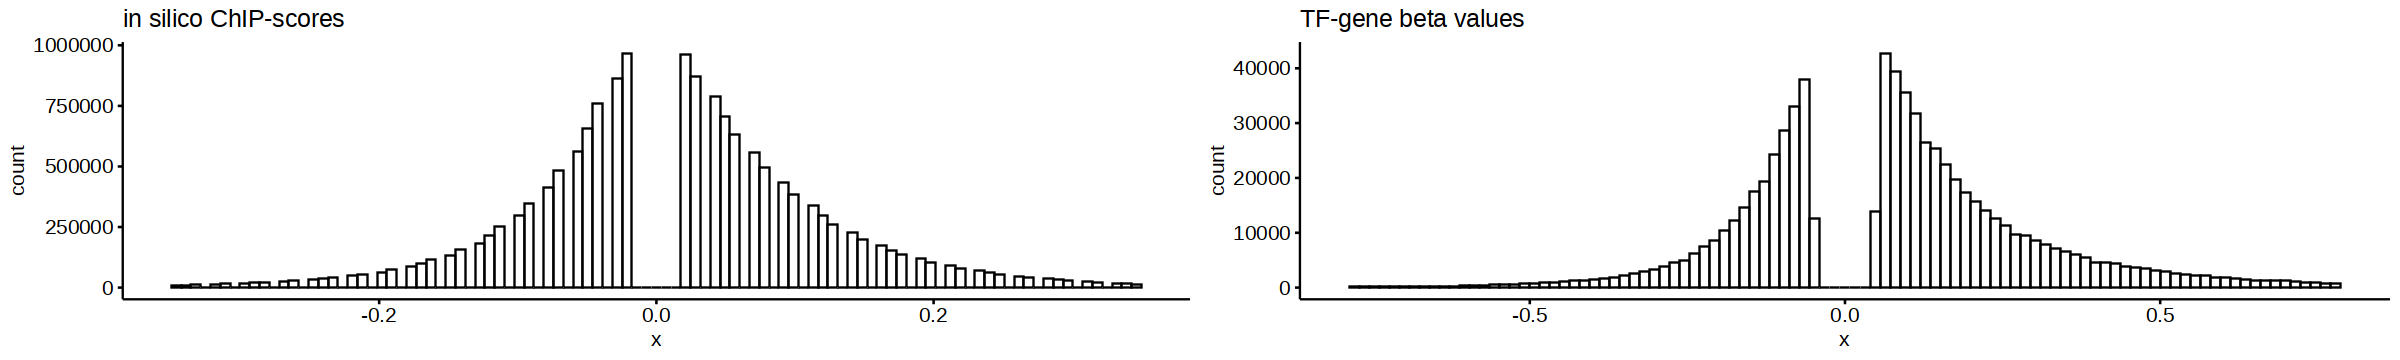

In [31]:
# Inspect silico ChIP-scores & TF-gene beta values
options(repr.plot.width=20, repr.plot.height=3)
chip_scores = as.vector(assay(motifmatcher_chip.se, 'VirtualChipScores'))
chip_scores = chip_scores[abs(chip_scores)>0.01]
p1 = gghistogram(chip_scores[abs(chip_scores)<quantile(abs(chip_scores), 0.99)], bins=100) + ggtitle('in silico ChIP-scores')
p2 = gghistogram(TF2Gene_links$beta[abs(TF2Gene_links$beta)>0.05 & abs(TF2Gene_links$beta)<quantile(abs(TF2Gene_links$beta), 0.99)], bins=100) + ggtitle('TF-gene beta values')
ggarrange(p1, p2)

In [32]:
suppressMessages(library(GGally))
suppressMessages(library(igraph))
#suppressMessages(library(network))
#suppressMessages(library(sna))
suppressMessages(library(ggraph))
suppressMessages(library(igraph))
suppressMessages(library(tibble))
suppressMessages(library(tidygraph))

In [33]:
#################
## Build GRN
#################
max_distance = 1.5e5
min_chip_score = 0.15
min_beta = 0.1
min_pvalue = 0.1
min_TF_expr = 5 # Min logcounts
TF_filter = NULL #c('GATA1', 'TAL1', 'HOXB8', 'LYL1')#c('HOXB8')
TF_TF_only = TRUE
motifmatcher_chip.se = motifmatcher_chip.se
assay = 'VirtualChipScores'
rna.sce = rna.sce
min_targets = 3
cores = detectCores()

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


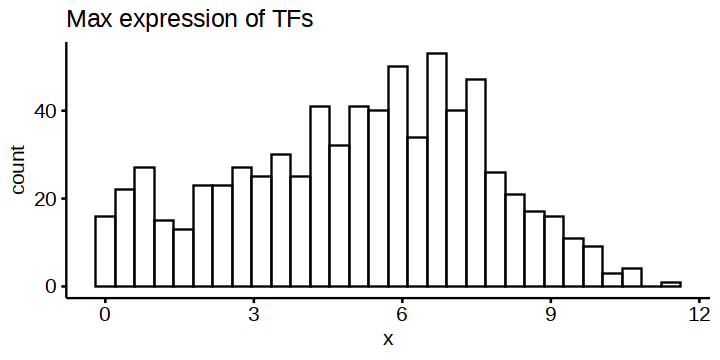

In [34]:
tf2gene_chip.dt <- mclapply(colnames(assay(motifmatcher_chip.se, assay)), function(i){
        virtual_chip.mtx = assay(motifmatcher_chip.se, assay)
        # Select target peaks (note that we only take positive correlations into account)
        target_peaks_i <- names(which(virtual_chip.mtx[,i]>=min_chip_score))
        if (length(target_peaks_i)>=1) {
            tmp <- data.table(
              tf = i,
              peak = target_peaks_i,
              chip_score = virtual_chip.mtx[target_peaks_i,i]
            ) %>% merge(peak2gene.dt[peak %in% target_peaks_i,c("peak","gene","dist")], by="peak")
            return(tmp)
            }
        }, mc.cores=cores) %>% rbindlist %>%
        .[,gene:=toupper(gene)] %>%
        .[chip_score >= min_chip_score & dist <= max_distance]

options(repr.plot.width=6, repr.plot.height=3)
max_expr = data.table(tf = unique(tf2gene_chip.dt$tf),
                      max_expr = rowMaxs(logcounts(rna.sce[str_to_title(unique(tf2gene_chip.dt$tf)),])))

gghistogram(max_expr$max_expr) + ggtitle('Max expression of TFs')
TF_keep = max_expr[max_expr>=min_TF_expr, toupper(tf)]

GRN_coef.dt <- TF2Gene_links %>% 
  .[pvalue<min_pvalue & abs(beta)>=min_beta] %>%
  .[,gene:=toupper(gene)] %>%
  .[tf %in% TF_keep]
if(!is.null(TF_filter)){
    GRN_coef.dt = GRN_coef.dt[tf %in% TF_filter]
}
if(TF_TF_only){
    GRN_coef.dt = GRN_coef.dt[gene %in% tf]
}

GRN.dt = merge(GRN_coef.dt, tf2gene_chip.dt, by=c('tf', 'gene')) %>% 
    .[,c('tf', 'peak', 'gene', 'dist', 'chip_score', 'beta', 'pvalue')] %>% 
    unique(by=c('tf', 'gene')) %>%
    .[,c('tf', 'gene', 'beta')] %>% 
    .[,N := .N, by='tf'] %>%
    .[N >= min_targets] 

if(TF_TF_only){
    GRN.dt = GRN.dt[gene %in% tf]
}

In [35]:
# Create node and edge data.frames
TFs <- unique(c(GRN.dt$tf,GRN.dt$gene))
node_list.dt <- data.table(node_id=1:length(TFs), node_name=TFs)
edge_list.dt <- GRN.dt[,c("tf","gene","beta")] %>% setnames(c("from","to","weight")) %>% .[!from==to]

# Create igraph object
igraph.net <- graph_from_data_frame(d = edge_list.dt)

# Create tbl_graph object for ggraph
igraph.tbl <- as_tbl_graph(igraph.net) %>%
  activate(nodes) %>%
  mutate(tf=names(V(igraph.net))) %>%
  mutate(degree=igraph::degree(igraph.net)) %>%
  mutate(eigen_centrality=eigen_centrality(igraph.net)$vector) %>%
  activate(edges) %>%
  mutate(sign=ifelse(E(igraph.net)$weight>0,"Positive","Negative")) %>%
  mutate(weight=abs(weight))

Warning message in eigen_centrality(igraph.net):
“At core/centrality/centrality_other.c:184 : Negative weight in graph. The largest eigenvalue will be selected, but it may not be the largest in magnitude.”


In [36]:
igraph.tbl

# A tbl_graph: 225 nodes and 8318 edges
#
# A directed simple graph with 1 component
#
# Edge Data: 8,318 × 4 (active)
   from    to weight sign    
  <int> <int>  <dbl> <chr>   
1     1     6  0.366 Positive
2     1    27  0.557 Positive
3     1    60  0.45  Positive
4     1    72  0.326 Positive
5     1    73  0.363 Positive
6     1    92  0.261 Positive
# … with 8,312 more rows
#
# Node Data: 225 × 4
  name   tf     degree eigen_centrality
  <chr>  <chr>   <dbl>            <dbl>
1 ALX1   ALX1       28            0.187
2 AR     AR         27            0.141
3 ARID5B ARID5B     83            0.389
# … with 222 more rows

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


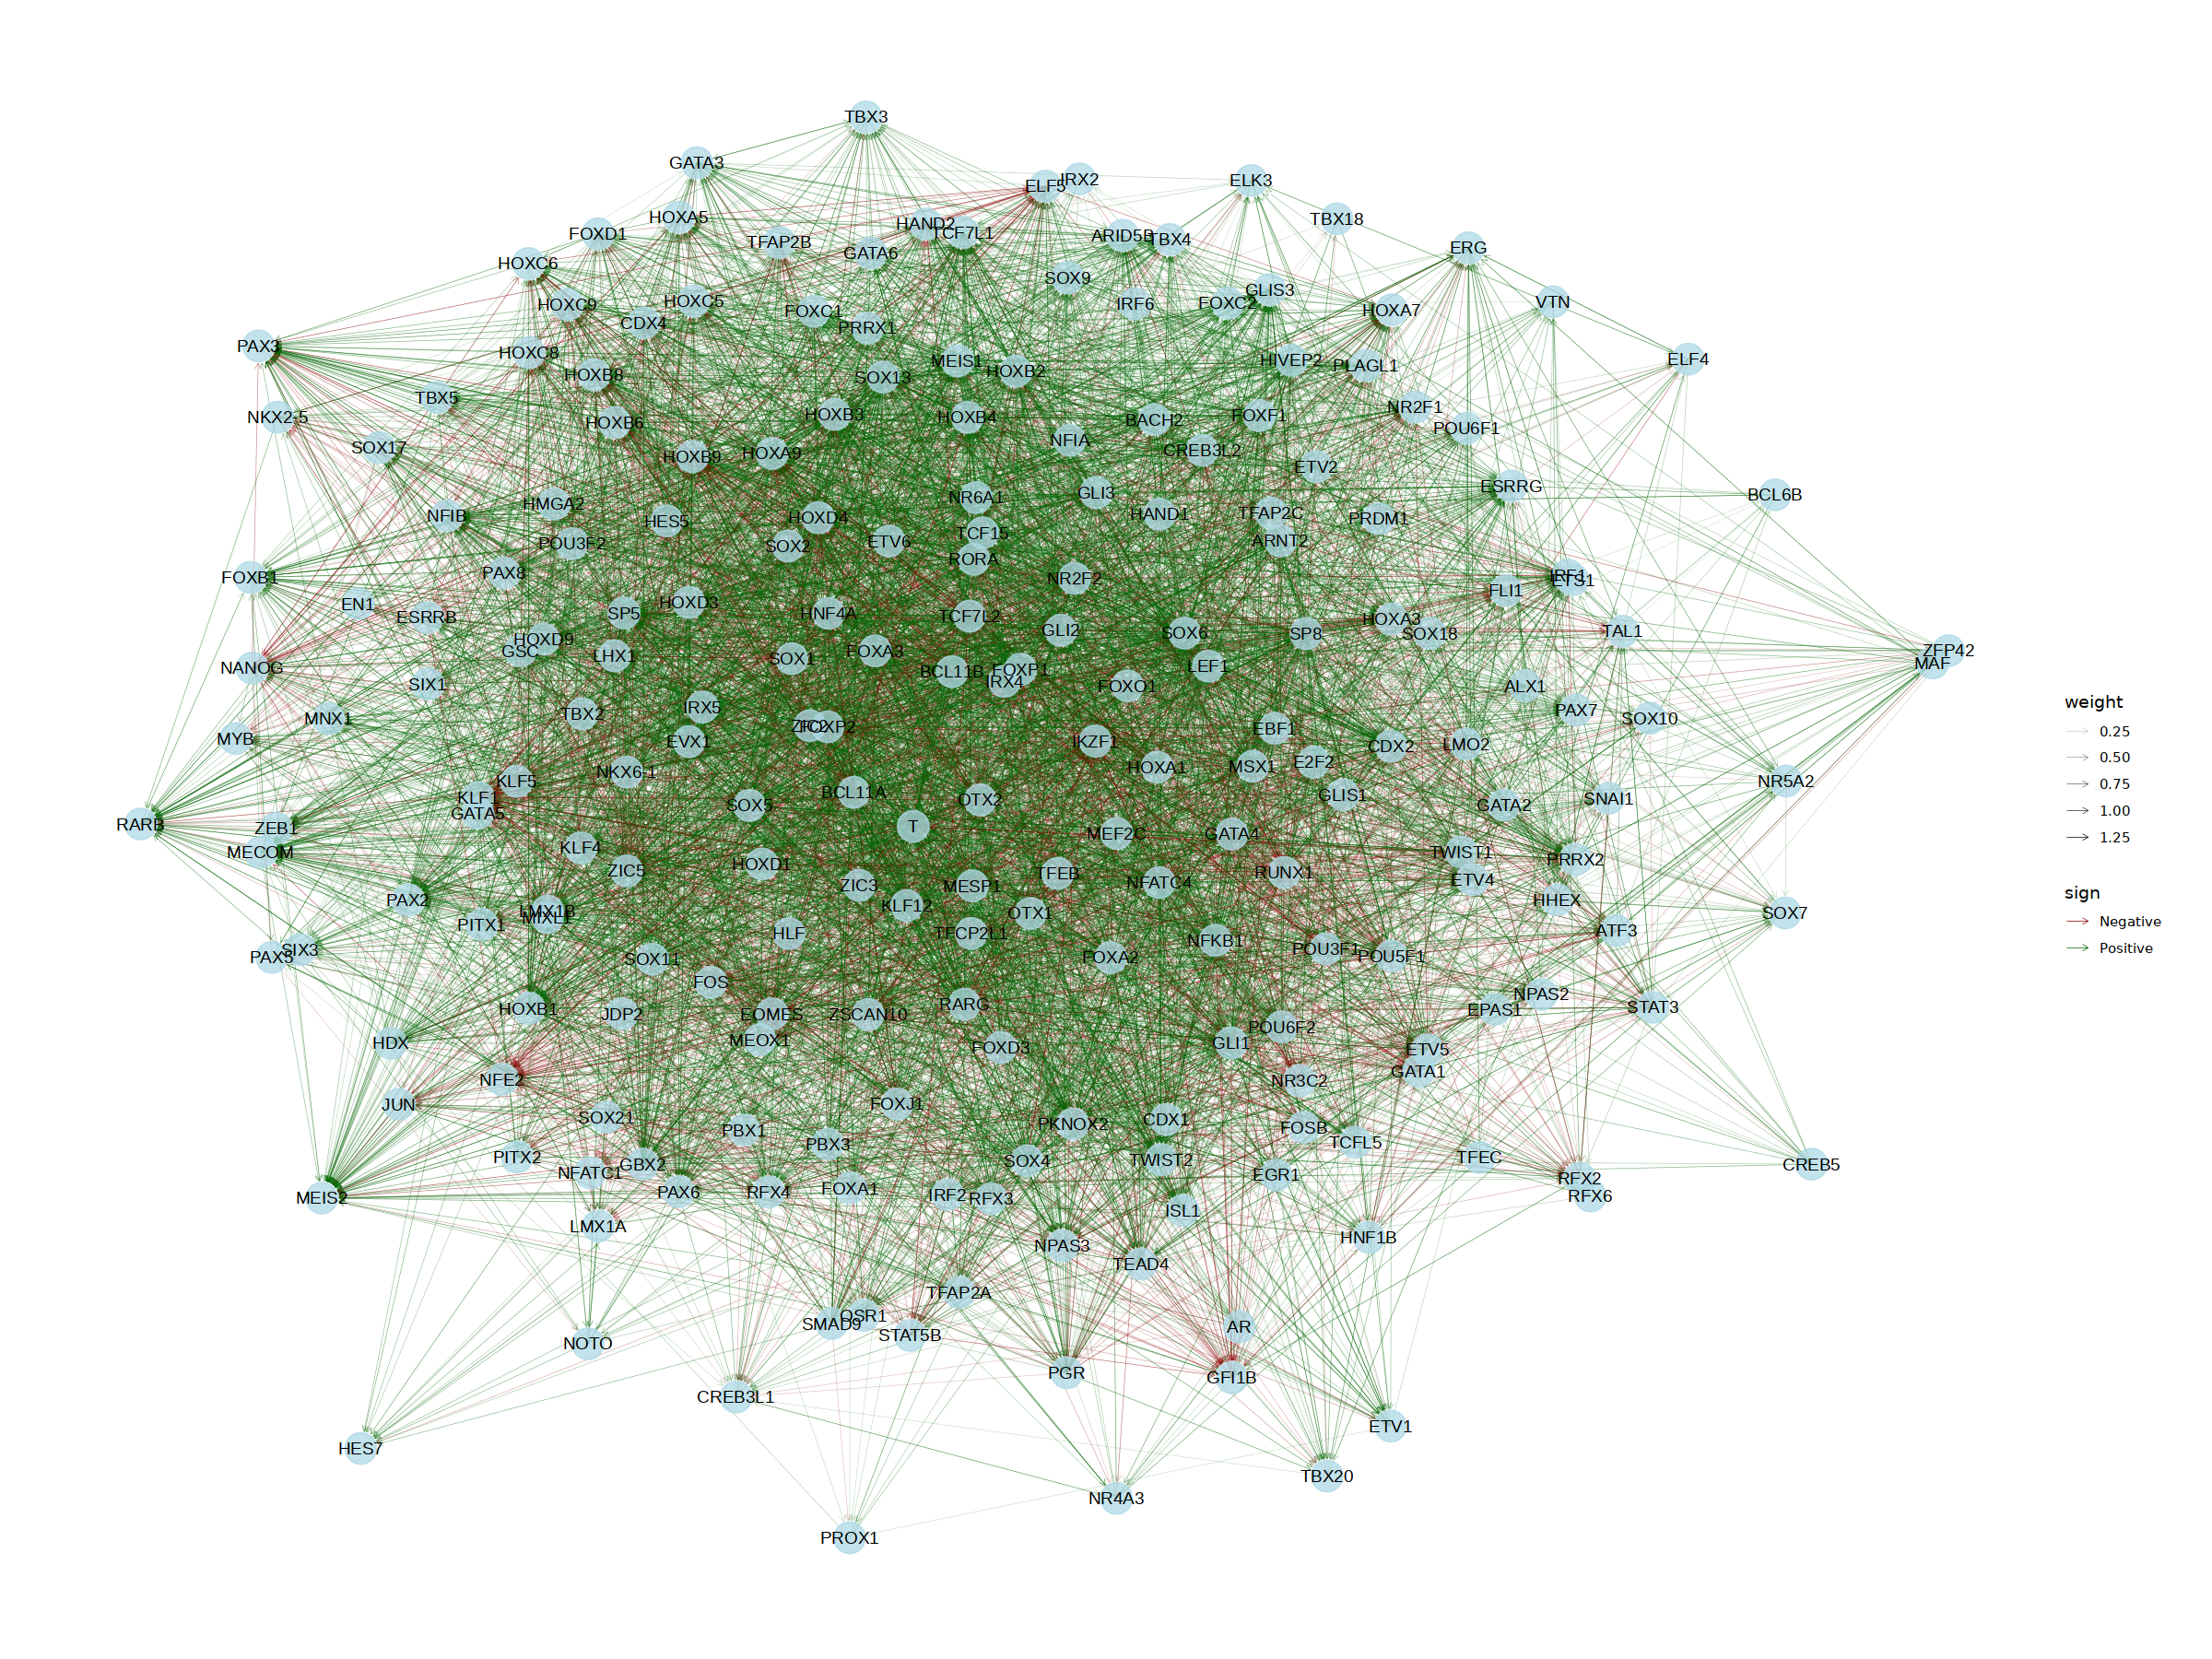

In [37]:
options(repr.plot.width=20, repr.plot.height=15)

ggraph(igraph.tbl, 'kk') +
  geom_edge_link(aes(edge_colour = sign, alpha=weight), edge_width=0.15, arrow=arrow(length=unit(1.5,'mm')), end_cap=circle(4,'mm')) +
  scale_edge_colour_manual(values=c("Positive"="darkgreen", "Negative"="darkred")) +
  geom_node_point(size=9, alpha=0.75, col='lightblue') +
  geom_node_text(aes(label = name)) +
  theme_graph()

# ChromVAR on single-cell data

In [ ]:
# io$ATAC_sce = file.path(io$outdir,sprintf("PeakMatrix_summarized_experiment_metacells.rds"))
# io$RNA_sce = file.path(io$outdir,"SingleCellExperiment_metacells.rds")

In [25]:
io$RNA_sce = file.path(io$basedir,"data/processed/rna/SingleCellExperiment.rds")
io$ATAC_sce = file.path(io$basedir,"data/processed/atac/archR/Matrices/PeakMatrix_summarized_experiment.rds")

In [26]:
#######################
## Load RNA and ATAC 
#######################

# Load SingleCellExperiment
rna.sce <- readRDS(io$RNA_sce)

# Load ATAC SummarizedExperiment
atac.sce <- readRDS(io$ATAC_sce)

# Make sure that samples are consistent
samples <- intersect(colnames(rna.sce),colnames(atac.sce))
rna.sce <- rna.sce[,samples]
atac.sce <- atac.sce[,samples]

print(sprintf("Number of metacells: %s",length(samples)))
# Normalise ATAC data
assayNames(atac.sce) <- "counts"
assay(atac.sce, 'logcounts') = assay(atac.sce, 'counts') # Try with TF-IDF normalisation
#assay(atac.sce,"logcounts") <- log(1e6*(sweep(assay(atac.sce),2,colSums(assay(atac.sce),na.rm=T),"/"))+1) # not possible for single-cell data due to massive file size

[1] "Number of metacells: 61886"


In [27]:
rna.sce
atac.sce

class: SingleCellExperiment 
dim: 32285 61886 
metadata(0):
assays(1): counts
rownames(32285): Xkr4 Gm1992 ... AC234645.1 AC149090.1
rowData names(0):
colnames(61886): E7.5_rep1#AAACAGCCAAACCCTA-1
  E7.5_rep1#AAACAGCCATCCTGAA-1 ... E8.5_CRISPR_T_WT#TTTGTTGGTGGCTTCC-1
  E8.5_CRISPR_T_WT#TTTGTTGGTTGGCCGA-1
colData names(10): barcode sample ... pass_rnaQC sizeFactor
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

class: RangedSummarizedExperiment 
dim: 192251 61886 
metadata(0):
assays(2): counts logcounts
rownames(192251): chr1:3035602-3036202 chr1:3062653-3063253 ...
  chrX:169925487-169926087 chrX:169937064-169937664
rowData names(1): idx
colnames(61886): E7.5_rep1#AAACAGCCAAACCCTA-1
  E7.5_rep1#AAACAGCCATCCTGAA-1 ... E8.5_CRISPR_T_WT#TTTGTTGGTGGCTTCC-1
  E8.5_CRISPR_T_WT#TTTGTTGGTTGGCCGA-1
colData names(35): BlacklistRatio nDiFrags ... ReadsInPeaks FRIP

In [29]:
rna.sce = logNormCounts(rna.sce)

In [30]:
# RNA dimreduction

decomp <- modelGeneVar(rna.sce)
decomp <- decomp[decomp$mean > 0.01,]
hvgs <- decomp[order(decomp$FDR),] %>% head(n=2500) %>% rownames

sce_filt <- rna.sce[hvgs,]
sce_filt <- runPCA(sce_filt, ncomponents = 35, ntop=2500)

In [31]:
sce_filt <- runUMAP(sce_filt, dimred="PCA", n_neighbors = 20, min_dist = 1.5)

umap.dt <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell"))

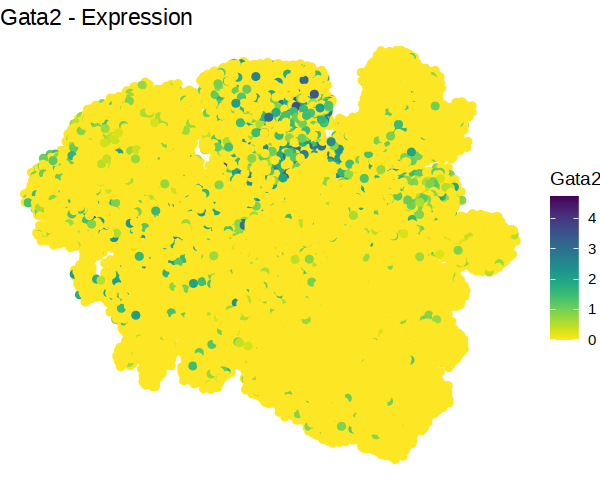

In [32]:
options(repr.plot.width=5, repr.plot.height=4)
gene = 'Gata2'
ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(rna.sce[gene,], 'logcounts')))) + 
    geom_point() +
    viridis::scale_color_viridis(begin=1, end=0, name=gene) + 
    ggtitle(paste0(gene, ' - Expression')) + 
    theme_void()

In [34]:
atac.sce

class: RangedSummarizedExperiment 
dim: 192251 61886 
metadata(0):
assays(2): counts logcounts
rownames(192251): chr1:3035602-3036202 chr1:3062653-3063253 ...
  chrX:169925487-169926087 chrX:169937064-169937664
rowData names(1): idx
colnames(61886): E7.5_rep1#AAACAGCCAAACCCTA-1
  E7.5_rep1#AAACAGCCATCCTGAA-1 ... E8.5_CRISPR_T_WT#TTTGTTGGTGGCTTCC-1
  E8.5_CRISPR_T_WT#TTTGTTGGTTGGCCGA-1
colData names(35): BlacklistRatio nDiFrags ... ReadsInPeaks FRIP

In [35]:
motifmatcher_chip.se

class: RangedSummarizedExperiment 
dim: 192251 732 
metadata(0):
assays(4): motifScores motifMatches motifCounts VirtualChipScores
rownames(192251): chr1:3035602-3036202 chr1:3062653-3063253 ...
  chrX:169925487-169926087 chrX:169937064-169937664
rowData names(13): score replicateScoreQuantile ... idx N
colnames(732): AHR AHRR ... ZKSCAN4 ZSCAN10
colData names(1): name

In [36]:
atac.sce = atac.sce
motifmatcher_chip.se = motifmatcher_chip.se
assay = 'VirtualChipScores'
background = bgdPeaks.se
genome = NULL # Only needed if background = NULL
positive_only = TRUE
min_chip_score = 0.15
min_number_peaks = 50
TFs_filt = NULL
test = FALSE
method = 'ArchR' # Option 'ArchR' or 'ChromVAR'
cores = detectCores()

In [37]:
    if(method == 'ChromVAR'){
        background = NULL
        cat('Background peaks recalculated for method = ChromVAR \n')
        if(is.null(genome)){
            cat('Please provide genome \n')
        }
    }
    
    if (positive_only){
      print(sprintf("Number of matches before filtering negative TF binding values: %d",sum(assay(motifmatcher_chip.se,"motifMatches"))))
      assay(motifmatcher_chip.se,"motifMatches")[assay(motifmatcher_chip.se, assay)<0] <- F
      print(sprintf("Number of matches after filtering negative TF binding values: %d",sum(assay(motifmatcher_chip.se,"motifMatches"))))
    }

    print(sprintf("Number of matches before filtering based on minimum ChIP-seq score: %d",sum(assay(motifmatcher_chip.se,"motifMatches"))))
    assay(motifmatcher_chip.se,"motifMatches")[abs(assay(motifmatcher_chip.se, assay))<=min_chip_score] <- F
    print(sprintf("Number of matches after filtering based on minimum ChIP-seq score: %d",sum(assay(motifmatcher_chip.se,"motifMatches"))))

    assays(motifmatcher_chip.se) <- assays(motifmatcher_chip.se)["motifMatches"]
    
    
    ## Filter TFs 
    # Filter TFs with too few peaks
    TFs <- which(colSums(assay(motifmatcher_chip.se,"motifMatches")) >= min_number_peaks) %>% names
    TFs.removed <- which(colSums(assay(motifmatcher_chip.se,"motifMatches")) < min_number_peaks) %>% names
    
    # Subset to TFs of interest
    if(!is.null(TFs_filt)){ 
        TFs = TFs[TFs %in% TFs_filt]
    }
    if(length(TFs.removed>0)){
        cat(sprintf("%s TFs removed because they don't have enough binding sites: %s \n", length(TFs.removed), paste(TFs.removed, collapse=" ")))
    }
    
    if(test){
      TFs <- c("FOXA2","MIXL1","GATA1","EOMES","BCL11B","DLX2","FOXC1")
    }
    
    motifmatcher_chip.se <- motifmatcher_chip.se[,TFs]    
    stopifnot(rownames(atac.sce)==rownames(motifmatcher.se))  
    
    if(!is.null(background)){
        ## Load background peaks
        bgdPeaks.se = background
        tmp <- rowRanges(bgdPeaks.se)
        rownames(bgdPeaks.se) <- sprintf("%s:%s-%s",seqnames(tmp), start(tmp), end(tmp))
        bgdPeaks.se <- bgdPeaks.se[rownames(atac.sce),] # subset to same peaks as in filtered atac.sce
        bg = assay(bgdPeaks.se)
    } else{
        ## Determine background peaks
        if(is.null(genome)){
            cat('Please provide genome \n')
            stop()
        }
    
        ## Filter non-accessible peaks
        peaks = rowSums(assay(atac.sce, 'counts'))>0
        atac.sce = atac.sce[peaks,]
        motifmatcher_chip.se = motifmatcher_chip.se[peaks,]   
        
        ## Calculate background peaks
        cat('Calculating background peaks \n')
        peaks = rownames(atac.sce_filt)
        library(GenomicRanges)
        gr <- GRanges(
            seqnames = Rle(peaks %>% str_split(':') %>% map_chr(1)),
            ranges = IRanges(start = as.numeric(peaks %>% str_split(':') %>% map_chr(2) %>% str_split('-') %>% map_chr(1)), 
                             end = as.numeric(peaks %>% str_split(':') %>% map_chr(2) %>% str_split('-') %>% map_chr(2))),
            strand = Rle(rep('*', length(peaks))))
        atac.rse = as(atac.sce_filt, 'RangedSummarizedExperiment')
        atac.rse@rowRanges = gr
        
        ## Adding background peaks
        atac.rse <- addGCBias(atac.rse, genome = genome)
        bg <- getBackgroundPeaks(object = atac.rse)
    }

[1] "Number of matches before filtering negative TF binding values: 18945532"
[1] "Number of matches after filtering negative TF binding values: 10714289"
[1] "Number of matches before filtering based on minimum ChIP-seq score: 10714289"
[1] "Number of matches after filtering based on minimum ChIP-seq score: 1409335"
9 TFs removed because they don't have enough binding sites: E2F3 HOXC12 PAX1 POU1F1 SIM2 TBX1 TBX18 TBX22 TOPORS 


In [38]:
rowData(atac.sce)

DataFrame with 192251 rows and 1 column
                             idx
                         <array>
chr1:3035602-3036202           1
chr1:3062653-3063253           2
chr1:3072313-3072913           3
chr1:3191496-3192096           4
chr1:3340575-3341175           5
...                          ...
chrX:169902806-169903406    3284
chrX:169905921-169906521    3285
chrX:169915616-169916216    3286
chrX:169925487-169926087    3287
chrX:169937064-169937664    3288

In [39]:


    
    ## ChromVAR ChIP-seq
    if(method == 'ArchR'){
        cat('Running ChromVAR-ChIP-seq (ArchR implementation) \n')
        
        featureDF <- data.frame(
          rowSums = rowSums(assay(atac.sce))#,
    #      start = rowData(atac.sce)$start,
    #      end = rowData(atac.sce)$end
        )

        # Compute deviations
        chromvar_deviations.se <- ArchR:::.customDeviations(
          countsMatrix = assay(atac.sce),
          annotationsMatrix = as(assay(motifmatcher_chip.se),"dgCMatrix"),
          backgroudPeaks = bg,
          expectation = featureDF$rowSums/sum(featureDF$rowSums),
          prefix = "",
          out = c("deviations", "z"),
          threads = cores,
          verbose = TRUE
        )
    } else if(method == 'ChromVAR'){
        cat('Running ChromVAR-ChIP-seq (ChromVAR implementation) \n')
        library(BiocParallel)
        #stop()
        register(MulticoreParam(cores))
        assayNames(atac.sce) <- "counts"

        # Compute deviations
        chromvar_deviations_chromvar.se <- chromVAR::computeDeviations(
          object = atac.sce,
          annotations = assay(motifmatcher_chip.se),
          background_peaks = bg
        )
        
    } else{
        print('Choose either option "ArchR" or "ChromVAR"')
    }

Running ChromVAR-ChIP-seq (ArchR implementation) 


as(<lgCMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "dMatrix") instead



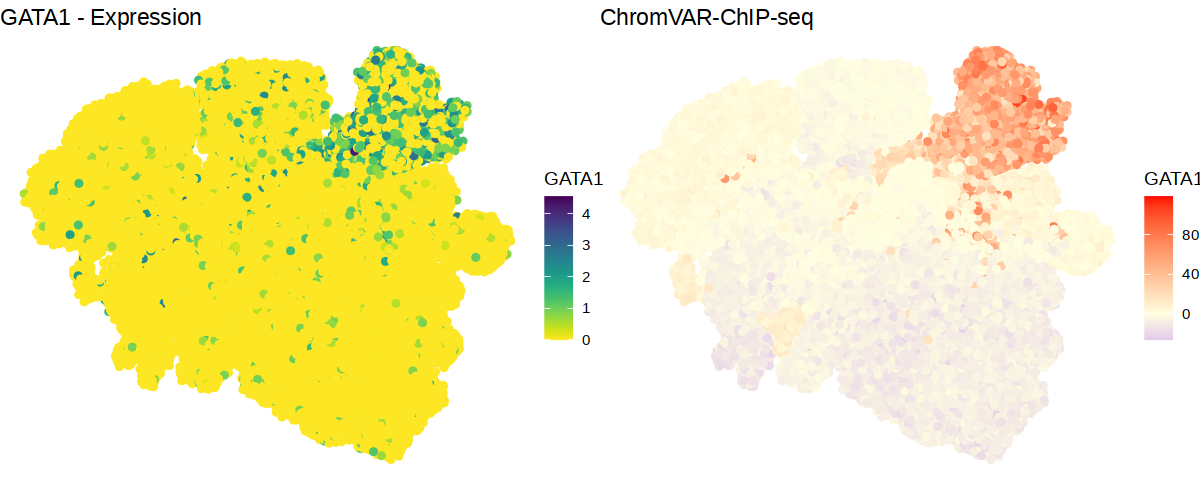

In [42]:
TF = 'GATA1'
p1 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(rna.sce, 'logcounts')[str_to_title(TF),]))) + 
    geom_point() +
    viridis::scale_color_viridis(begin=1, end=0, name=TF) + 
    ggtitle(paste0(TF, ' - Expression')) + 
    theme_void()

p2 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(chromvar_deviations.se, 'z')[TF,]))) + 
    geom_point() +
    scale_color_gradient2(low='blue', mid='lightyellow', high='red', name=TF) + 
    ggtitle('ChromVAR-ChIP-seq') + 
    theme_void()
options(repr.plot.width=10, repr.plot.height=4)
ggarrange(p1, p2, nrow = 1)

In [33]:
######################################
## ChromVAR - ChIP-seq
######################################
a = Sys.time()
# load background peak set
bgdPeaks.se <- readRDS(io$background_peaks)

chromvar_deviations.se = chromVAR_chip(atac.sce = atac.sce, 
                                                   motifmatcher_chip.se = motifmatcher_chip.se,
                                                   assay = 'VirtualChipScores',
                                                   background = bgdPeaks.se,
                                                   genome = NULL, # Only needed if background = NULL
                                                   positive_only = TRUE, 
                                                   min_chip_score = 0.15,
                                                   min_number_peaks = 50,
                                                   TFs_filt = NULL,
                                                   test = FALSE,
                                                   method = 'ArchR', # Option 'ArchR' or 'ChromVAR'
                                                   cores = detectCores())
b = Sys.time()
b-a

[1] "Number of matches before filtering negative TF binding values: 18945532"
[1] "Number of matches after filtering negative TF binding values: 10714289"
[1] "Number of matches before filtering based on minimum ChIP-seq score: 10714289"
[1] "Number of matches after filtering based on minimum ChIP-seq score: 1409335"
9 TFs removed because they don't have enough binding sites: E2F3 HOXC12 PAX1 POU1F1 SIM2 TBX1 TBX18 TBX22 TOPORS 
Running ChromVAR-ChIP-seq (ArchR implementation) 


ERROR: Error in data.frame(rowSums = rowSums(assay(atac.sce)), start = rowData(atac.sce)$start, : arguments imply differing number of rows: 192251, 0


In [ ]:
chromvar_deviations_original.se = chromVAR_chip(atac.sce = atac.sce, 
                                                   motifmatcher_chip.se = motifmatcher_chip.se,
                                                   assay = 'motifScores',
                                                   background = bgdPeaks.se,
                                                   genome = NULL, # Only needed if background = NULL
                                                   positive_only = FALSE, 
                                                   min_chip_score = 0,
                                                   min_number_peaks = 50,
                                                   TFs_filt = NULL,
                                                   test = FALSE,
                                                   method = 'ArchR', # Option 'ArchR' or 'ChromVAR'
                                                   cores = detectCores())

In [ ]:
TF = 'GATA1'

p1 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(rna.sce, 'logcounts')[str_to_title(TF),]))) + 
    geom_point() +
    viridis::scale_color_viridis(begin=1, end=0, name=TF) + 
    ggtitle(paste0(TF, ' - Expression')) + 
    theme_void()

p2 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(chromvar_deviations.se, 'z')[TF,]))) + 
    geom_point() +
    scale_color_gradient2(low='blue', mid='lightyellow', high='red', name=TF) + 
    ggtitle('ChromVAR-ChIP-seq') + 
    theme_void()

p3 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(chromvar_deviations_original.se, 'z')[TF,]))) + 
    geom_point() +
    scale_color_gradient2(low='blue', mid='lightyellow', high='red', name=TF) + 
    ggtitle('ChromVAR-original') + 
    theme_void()
options(repr.plot.width=15, repr.plot.height=4)
ggarrange(p1, p2, p3, nrow = 1)

In [ ]:
GRN.dt

In [152]:
io$cell2metacell <- file.path(io$outdir, "cell2metacell_assignment.txt.gz")


In [153]:
cell2metacell = fread(io$cell2metacell)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


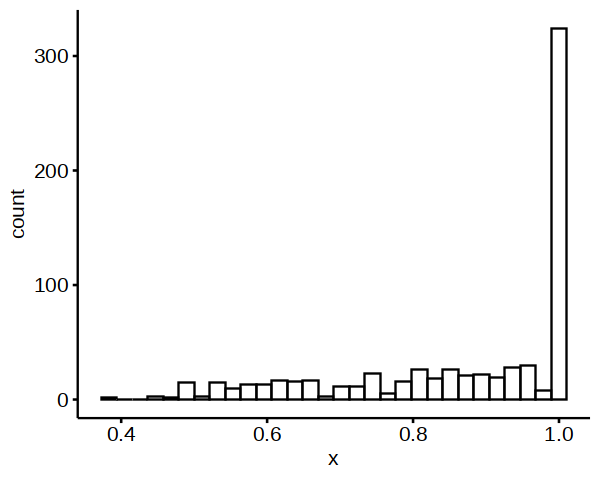

In [156]:
gghistogram(cell2metacell %>% unique(by='metacell') %>% .$celltype_purity)

In [154]:
head(cell2metacell)

cell                         metacell                     celltype      
1 E7.5_rep1#AAACAGCCATCCTGAA-1 E7.5_rep1#AAACAGCCATCCTGAA-1 Mixed_mesoderm
2 E7.5_rep1#CTTAGTTTCATCCTCA-1 E7.5_rep1#AAACAGCCATCCTGAA-1 Mixed_mesoderm
3 E7.5_rep1#GCACATTAGTTTGGGT-1 E7.5_rep1#AAACAGCCATCCTGAA-1 Mixed_mesoderm
4 E7.5_rep1#TCACTGACAGGCTAAG-1 E7.5_rep1#AAACAGCCATCCTGAA-1 Mixed_mesoderm
5 E7.5_rep2#ACACGGACACCTGCTC-1 E7.5_rep1#AAACAGCCATCCTGAA-1 Mixed_mesoderm
6 E7.5_rep2#ATGAGCCGTAAATTGC-1 E7.5_rep1#AAACAGCCATCCTGAA-1 Mixed_mesoderm
  celltype_purity
1 0.5454545      
2 0.5454545      
3 0.5454545      
4 0.5454545      
5 0.5454545      
6 0.5454545